In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts


from mne_connectivity import spectral_connectivity_epochs
from mne.datasets import sample
import seaborn as sns

from scipy.signal import welch
import yasa
import constants
import numpy as np

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [4]:
data_types = ['N1', 'N2' , 'N3' , 'REM']
data_type = 'N2'
paths = joblib.load('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/' + data_type + '_paths.pkl')

In [14]:
%%capture captured_output
t1 = time.time()
len_epochs = []
for path in paths['selected_paths']:
    data_epo = mne.read_epochs(path)
    df_full = data_epo.to_data_frame()
    len_epochs.append(len(df_full))

t2 = time.time()

Text(0.5, 1.0, 'Length of N2 data in epochs')

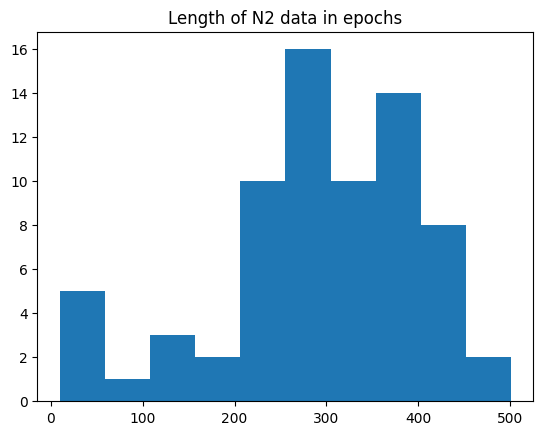

In [20]:
plt.hist([val  / (30*256) for val in len_epochs])
plt.title('Length of N2 data in epochs') 

In [43]:
epoch_lengths = [val  / (30*256) for val in len_epochs]
selected_epoch_lengths = [10.0 , 33.0, 48.0, 56.0, 72.0 , 120.0, 142.0]
selected_indices = [epoch_lengths.index(val) for val in selected_epoch_lengths]
selected_indices

[33, 0, 1, 34, 25, 62, 35]

In [47]:
mne.read_epochs(paths['selected_paths'][path_num])

Reading /user/work/ko20929/fif_files/N2_data/RBD_2206_Night 1_N2.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 55) active
    Found the data of interest:
        t =       0.00 ...   29996.09 ms
        0 CTF compensation matrices available
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


/tmp/ipykernel_127903/964056680.py:1: RuntimeWarning: This filename (/user/work/ko20929/fif_files/N2_data/RBD_2206_Night 1_N2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  mne.read_epochs(paths['selected_paths'][path_num])


Number of events,10
Events,N2: 10
Time range,0.000 – 29.996 s
Baseline,off


In [49]:
%%capture captured_output

times = []

for path_num in selected_indices:
    t1 = time.time()
    connectivity_df_list = []
    for path in [paths['selected_paths'][path_num]]:
        #1. Load the data 
        channels = constants.channel_list
        
        print(path)
        data_epo = mne.read_epochs(path)
        df_full = data_epo.to_data_frame()
        
        # 2. Define the power bands
        
        power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) }
        
        fmin = [float(val[0]) for val in power_bands.values()]
        fmax = [float(val[1]) for val in power_bands.values()]
        
        #generate coherence data across electrodes
        con_pli =  spectral_connectivity_epochs(data_epo , method='coh' , sfreq=256,fmin=fmin, fmax=fmax, faverage=True)
        
        #3. Generate all of the power band dataframes for that sample and add to power_band_coherence_dfs dictionary
        power_band_coherence_dfs = {}
        for power_band_index, power_band in enumerate(list(power_bands.keys())):
            
            channel_names = channels
            connectivity_data = con_pli.get_data('dense')[:, : , power_band_index]
            
            channel_data = connectivity_data
            
            # Create an empty DataFrame
            df = pd.DataFrame(index=channel_names, columns=channel_names)
            
            # Fill the DataFrame with connectivity values
            for i in range(len(channel_names)):
                for j in range(len(channel_names)):
                    channel_1 = channel_names[i]
                    channel_2 = channel_names[j]
                    connectivity_value = channel_data[i, j]
                    df.loc[channel_1, channel_2] = connectivity_value
                    df.loc[channel_2, channel_1] = connectivity_value
            
            df = df.apply(pd.to_numeric)
            
            power_band_coherence_dfs[power_band] = df
        
        new_df_row = {}
        
        #4. Go through all of the power_bands and add data as a column for a new dataframe with power_band + channel_1 + channel_2 as feature(s) 
        for power_band in list(power_bands.keys()):
            print(power_band)
            df = power_band_coherence_dfs[power_band]
            for i, channel in enumerate(channels):
                for channel_2 in channels[i+1:]:
                    val = df.loc[channel, channel_2]
                    new_df_row[power_band + '_' + channel + '_' + channel_2] = [val]
        
        new_df = pd.DataFrame.from_dict(new_df_row, orient = 'columns')
    
        connectivity_df_list.append(new_df)

    t2 = time.time()
    print(t2-t1)
    times.append(t2-t1)


In [ ]:
6018294

In [70]:
(30*0.8*71) / 60

28.4

In [63]:
( (300*0.8 )*71 ) / 60

284.0

In [65]:
284 / 60 

4.733333333333333

In [66]:
sys.argv[1]

'-f'

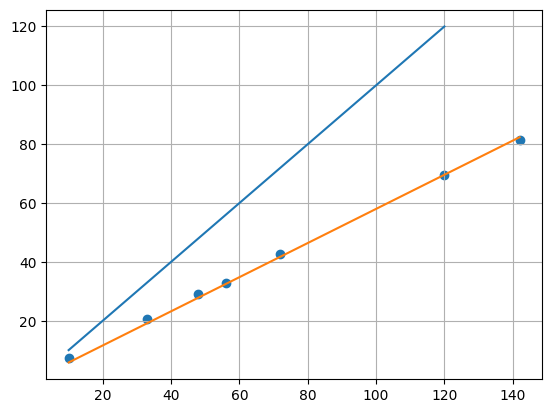

In [59]:
plt.scatter(selected_epoch_lengths, times)
plt.plot(selected_epoch_lengths[:6], selected_epoch_lengths[:6])
plt.plot(np.array(selected_epoch_lengths), np.array(selected_epoch_lengths) *0.58)
plt.grid()